## Research Question

<io>
    1. DBscan과 K-means clustering을 기반으로 조금 더 정확한 군집화를 해보고자 함 <br>
    2. 제약조건(각 지역별 최대 면적) 등을 기반으로 Constrained K-Means Clustering 논문과 유사하게 해보고자 노력함 <br>
    3. 주로 밀도 군집화 등에 사용되는 geomtry 데이터를 기반으로 하고자 함 <br>
    
    -문제 생성-
    1. 각 시.도별 교육환경구역을 바탕으로, "교육환경구역 내 안전한 학습 환경 조성" 을 위한 관리 필요 지역 식별 및 인원 할당
    2. 적절한 군집화를 기준으로 각 시.도 별로 직원 파견 등을 통하여 보안, 교통 등에 인원배분을 하기 위한 최적 클러스터링 탐구
    3. 이후, 각 시.도별 공무원 수, 각 클러스터된 군집 별로 사고 발생 수 등을 얻을 수 있다면 해당 지역의 안전문제 예방, 관리 전략 세울 수 있을 것

## 브이월드 교육환경구역 다운

In [64]:
import requests
import pandas as pd
import time


def crawl(start_num, end_num):
    print(start_num, '~', end_num)
    code = pd.read_csv('읍면동코드.csv')

    df=pd.DataFrame()
    for i in range(start_num, end_num):
        cc = code['행정구역'][i]
        emdcd = code['code'][i]
        key = '보안' #
        url='https://api.vworld.kr/req/data?service=data&request=GetFeature&data=LT_C_UO101&&key='+key+'&attrFilter=emdCd:=:'+str(emdcd)
        #url='https://api.vworld.kr/req/data?service=data&output=json&request=GetFeature&data=LT_C_AGRIXUE101&key='+key+'&attrFilter=emdCd:=:'+str(emdcd)
        #유치원보호구역/농촌 으로 나눔
        try: #request가 잘 될때 기준
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()
            if (data['response']['status'] != 'NOT_FOUND'): #데이터가 존재하는 경우에만
                if 'response' in data and 'result' in data['response']: #result 값이 존재한다면
                    for i in range(0, len(data['response']['result']['featureCollection']['features'])):
                        pro = data['response']['result']['featureCollection']['features'][i]['properties']
                        df1 = pd.DataFrame([pro])
                        type1 = data['response']['result']['featureCollection']['features'][i]['geometry']['type']
                        gem = data['response']['result']['featureCollection']['features'][i]['geometry']['coordinates'][0]
                        df1['type'] = type1
                        df1['gem'] = str(gem)
                        df1['emdcd'] = emdcd
                        df1['행정구역'] = cc
                        df = pd.concat([df, df1])
                    df = df.drop_duplicates(subset=['type', 'gem'])
        except requests.RequestException as e: #오류 발생시 예외 처리하고 그 다음 반복문으로 진행 할 수 있도록
            print(f"{code} 데이터를 가져오는 중 에러 발생: {e}")
        time.sleep(1)
    df.to_csv(str(start_num)+'~'+str(end_num)+'.csv', encoding='cp949')
    return df


In [65]:
import os
import multiprocessing
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, TimeoutError
import pandas as pd

code = pd.read_csv('읍면동코드.csv')
last = len(code)

ranges = [(i, i + 1000) for i in range(0, 5000, 1000)] + [(5000, last)]
result_data = pd.DataFrame()


def get_physical_cores():
    if os.name == 'posix':  # For Linux and macOS
        return int(os.environ.get('OMP_NUM_THREADS', multiprocessing.cpu_count() // 2))
    elif os.name == 'nt':  # For Windows
        return int(os.environ.get('NUMBER_OF_PROCESSORS', multiprocessing.cpu_count() // 2))
    else:
        return multiprocessing.cpu_count() // 2

physical_cores = get_physical_cores() #물리코어 사용
num_threads = physical_cores//2
print(num_threads)

with ThreadPoolExecutor(max_workers=num_threads) as executor:
    results = executor.map(lambda x: crawl(*x), ranges)
    for group_data_s in results:
        result_data = pd.concat([result_data, group_data_s])
        
result_data.to_csv('교육환경보호구역_폴리곤.csv', encoding='cp949')


4
0 ~ 1000
1000 ~ 2000
2000 ~ 3000
3000 ~ 4000
4000 ~ 5000
5000 ~ 5049


### 만일 gpd.GeoDataFrame(df, geometry='polygon') 가 이상하면 여기서 부터 할것, 위는 멀티프로세스라 시간잡아먹으

In [19]:
import ast
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon
import geopandas as gpd
import pandas as pd
import numpy as np

df = pd.read_csv('교육환경보호구역_폴리곤.csv', encoding='cp949', index_col=0, low_memory=False)
df = df.drop_duplicates(subset=['type', 'gem'])

def polygon(polygon_str, poly_type):
    try:
        coordinates = ast.literal_eval(polygon_str)
        if poly_type == 'MultiPolygon': #type에 저장해놓았으므로 그거 이용 Polygon 패키지 내부 이용 문자열 polygon 형태로 변환
            multi_polygon = MultiPolygon([Polygon(coords) for coords in coordinates])
            return multi_polygon
        else:
            polygon = Polygon(coordinates_list[0])  # Assuming the first set of coordinates for single polygons
            return polygon
    except Exception as e:
        return None
    
df['polygon'] = df.apply(lambda row: polygon(row['gem'], row['type']), axis=1)
df['area'] = df['polygon'].apply(lambda poly: poly.area) #shapely 패키지 내부의 폴리곤 area 계산 함수 적용

df.to_csv('교육환경보호구역_폴리곤_정제.csv', encoding='cp949')

In [20]:
import pandas as pd

#df= pd.read_csv('교육환경보호구역_폴리곤_정제.csv', encoding='cp949', index_col=0)
df1 = pd.read_csv('읍면동코드.csv')
df1 = df1[['code', '지역']]
df = df.merge(df1, left_on=['emdcd'], right_on=['code'], how='left')
df = df.drop(columns='code')
df.head()
df.to_csv('교육환경보호구역_폴리곤_정제_지역포함.csv', encoding='cp949')

### polygon 기반 그래프 간단히 그려봄

<Figure size 1000x1000 with 0 Axes>

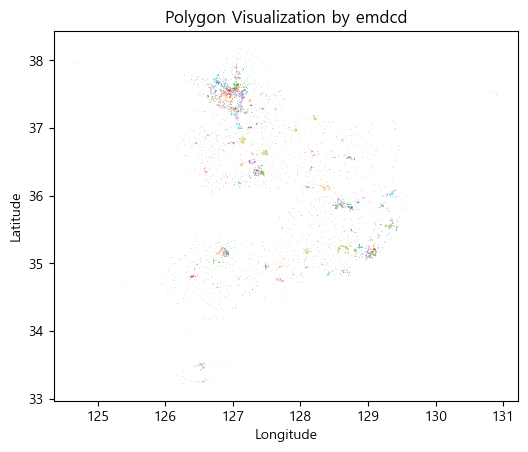

In [21]:
# GeoDataFrame 생성
gdf_by_index = gpd.GeoDataFrame(df, geometry='polygon')

# Plotting with a legend
plt.figure(figsize=(10, 10))
gdf_by_index.plot(column='sigg_name')
plt.title("Polygon Visualization by emdcd")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## 각 geometry 기준, 중심점을 구하여서 dbscan으로 집단을 나누어봄

In [22]:
from sklearn.cluster import DBSCAN
import geopandas as gpd
from shapely.ops import nearest_points
from shapely.geometry import Polygon, MultiPolygon, Point
from math import radians, sin, cos, sqrt, atan2
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def get_polygon_centroid(polygon):
    if isinstance(polygon, Polygon): #polygon인 경우, centroid를 바로 적용
        return polygon.centroid
    elif isinstance(polygon, MultiPolygon):
        centroids = [p.centroid for p in polygon.geoms] #multi의 경우 각 polygon의 중심점을 구하고
        avg_x = sum([point.x for point in centroids]) / len(centroids) #평균 x 좌표
        avg_y = sum([point.y for point in centroids]) / len(centroids) #평균 y 좌표를 구한다
        return Point(avg_x, avg_y)
    return None

#df = pd.read_csv('교육환경보호구역_폴리곤_정제_지역포함.csv', encoding='cp949')
gdf = gpd.GeoDataFrame(df, geometry='polygon')
centroids = gdf['polygon'].apply(get_polygon_centroid)

In [23]:
centroids

0        POINT (126.96954 37.58583)
1        POINT (126.96937 37.58574)
2        POINT (126.96915 37.58797)
3        POINT (126.97180 37.58575)
4        POINT (126.97124 37.58564)
                    ...            
19527    POINT (126.81471 33.35292)
19528    POINT (126.81419 33.35172)
19529    POINT (126.81493 33.35207)
19530    POINT (126.77751 33.31205)
19531    POINT (126.77819 33.31199)
Name: polygon, Length: 19532, dtype: geometry

In [24]:
gdf.head()

,uname,dyear,dnum,sido_name,sigg_name,remark,type,gem,emdcd,행정구역,polygon,area,지역
0,절대보호구역,2018,69,서울특별시,종로구,"서울청운초등학교병설유치원, 서울청운초등학교 절대보호구역",MultiPolygon,"[[[126.96817672517435, 37.58623144576946], [12...",11110101,11110,"MULTIPOLYGON (((126.96818 37.58623, 126.96818 ...",1.722362e-06,서울특별시 종로구 청운동
1,상대보호구역,2018,69,서울특별시,종로구,"서울청운초등학교, 서울청운초등학교병설유치원 상대보호구역",MultiPolygon,"[[[126.96622364977378, 37.58587578152975], [12...",11110101,11110,"MULTIPOLYGON (((126.96622 37.58588, 126.96623 ...",2.574540e-05,서울특별시 종로구 청운동
2,절대보호구역,2020,132,서울특별시,종로구,NaN,MultiPolygon,"[[[126.96957527782257, 37.58762799954203], [12...",11110101,11110,"MULTIPOLYGON (((126.96958 37.58763, 126.96956 ...",3.646685e-07,서울특별시 종로구 청운동
3,절대보호구역,2020,132,서울특별시,종로구,NaN,MultiPolygon,"[[[126.97204485745192, 37.586077199111536], [1...",11110101,11110,"MULTIPOLYGON (((126.97204 37.58608, 126.97206 ...",2.260572e-07,서울특별시 종로구 청운동
4,절대보호구역,2020,132,서울특별시,종로구,NaN,MultiPolygon,"[[[126.97135846275943, 37.58544601144458], [12...",11110101,11110,"MULTIPOLYGON (((126.97136 37.58545, 126.97133 ...",1.185394e-07,서울특별시 종로구 청운동


## 각 sido (시도 별) dbscan 결과

In [25]:
gdf['sido_name'].unique()

array(['서울특별시', '인천광역시', '경기도', '부산광역시', '경상남도', '대구광역시', '경상북도', '광주광역시',
       '전라남도', '대전광역시', '충청남도', '울산광역시', '세종특별자치시', '충청북도', '전라북도',
       '제주특별자치도'], dtype=object)

In [26]:
names = gdf['sido_name'].unique()
gdf_dic = {}
centroids_dic = {}
for name in names:
    gdf1 = gdf[gdf['sido_name'] == name].copy()
    centroids1 = gdf1['polygon'].apply(get_polygon_centroid)
    gdf_dic[name] = gdf1
    centroids_dic[name] = centroids1


<Figure size 1000x1000 with 0 Axes>

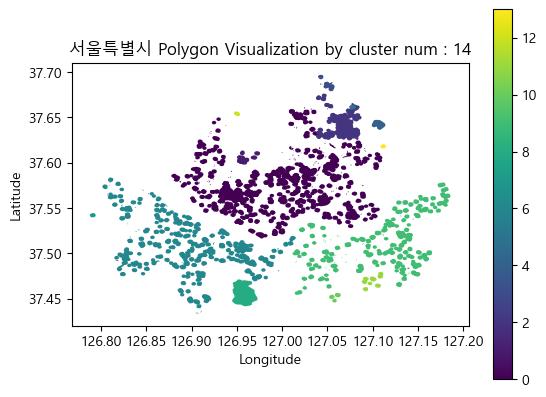

<Figure size 1000x1000 with 0 Axes>

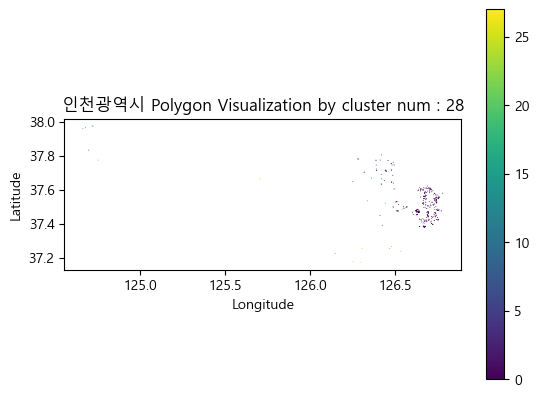

<Figure size 1000x1000 with 0 Axes>

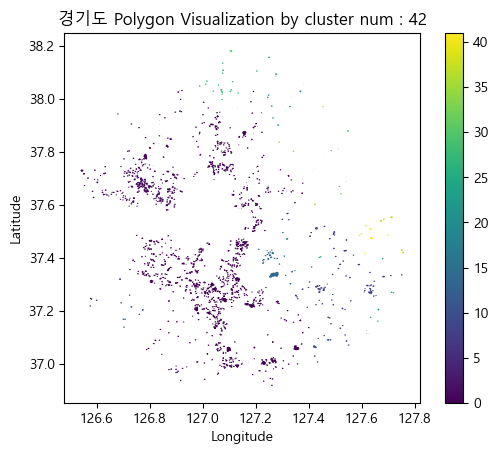

<Figure size 1000x1000 with 0 Axes>

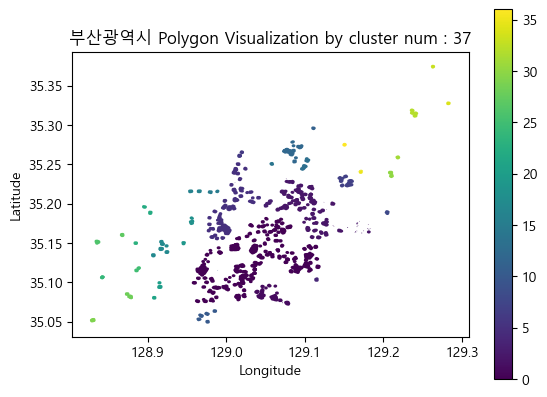

<Figure size 1000x1000 with 0 Axes>

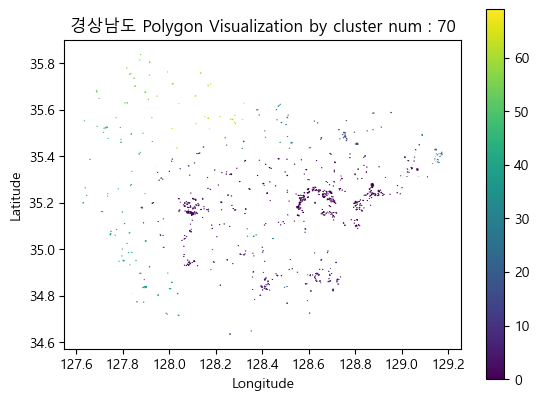

<Figure size 1000x1000 with 0 Axes>

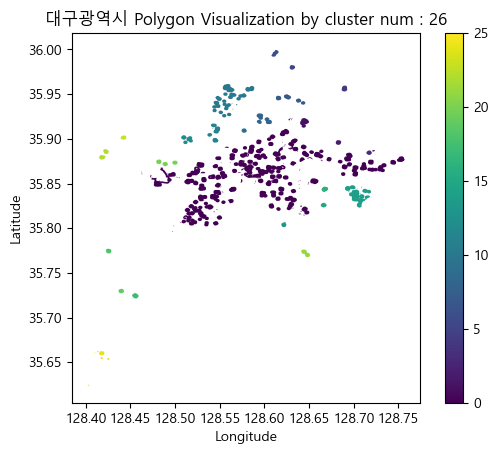

<Figure size 1000x1000 with 0 Axes>

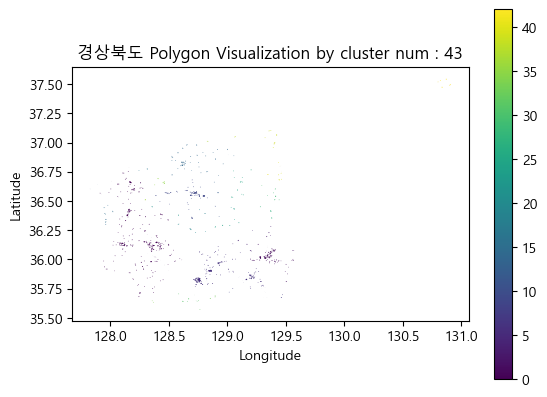

<Figure size 1000x1000 with 0 Axes>

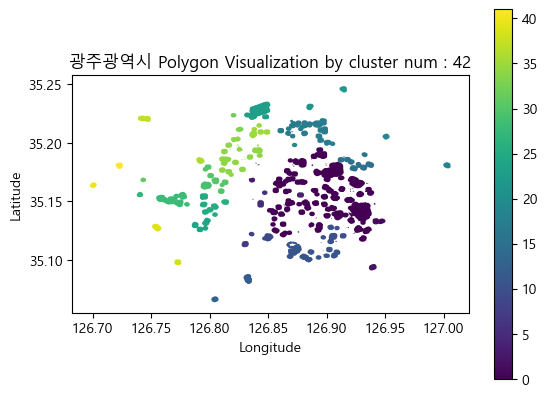

<Figure size 1000x1000 with 0 Axes>

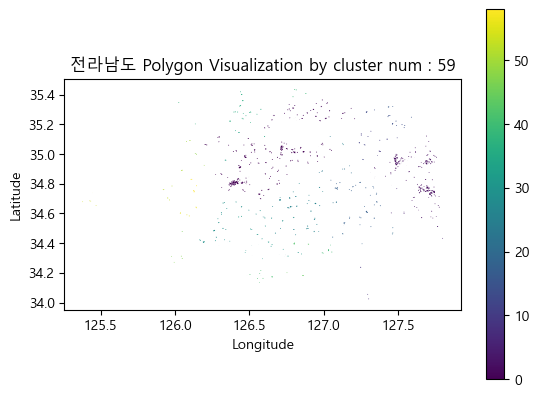

<Figure size 1000x1000 with 0 Axes>

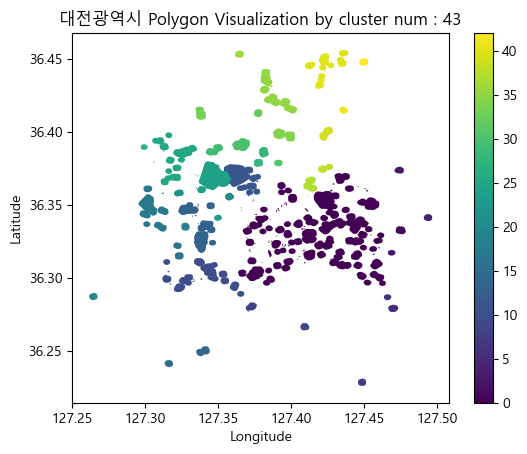

<Figure size 1000x1000 with 0 Axes>

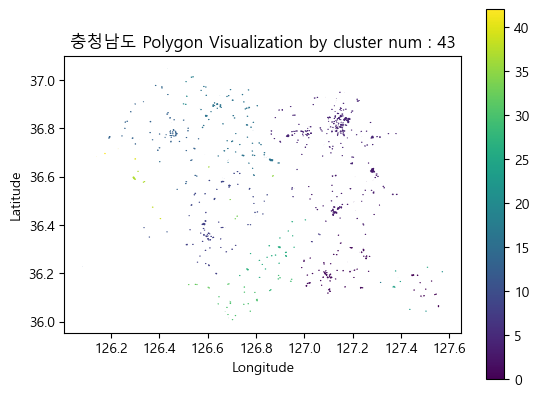

<Figure size 1000x1000 with 0 Axes>

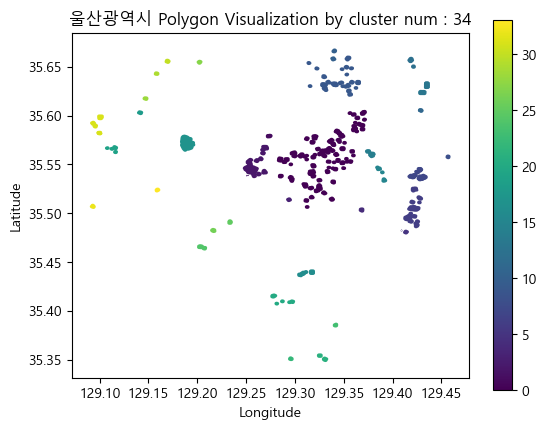

<Figure size 1000x1000 with 0 Axes>

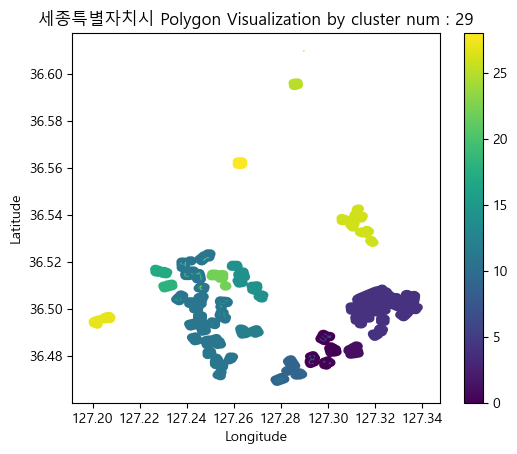

<Figure size 1000x1000 with 0 Axes>

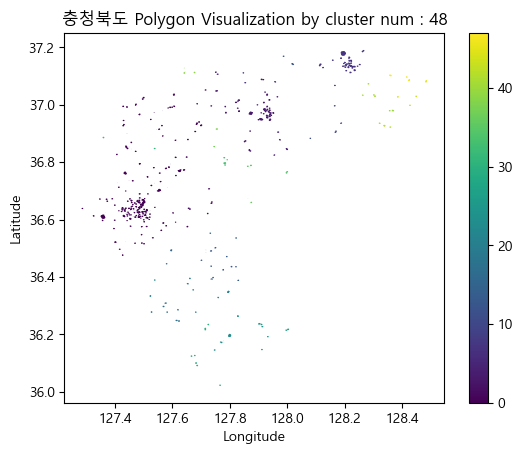

<Figure size 1000x1000 with 0 Axes>

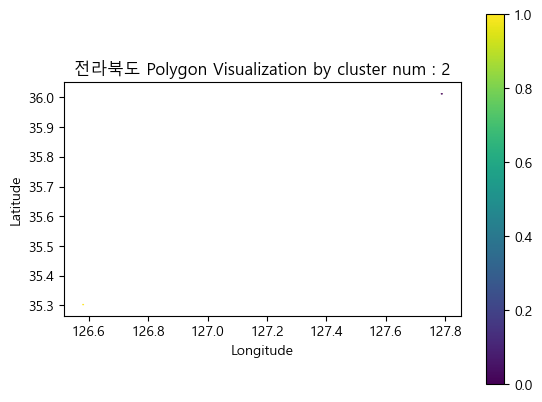

<Figure size 1000x1000 with 0 Axes>

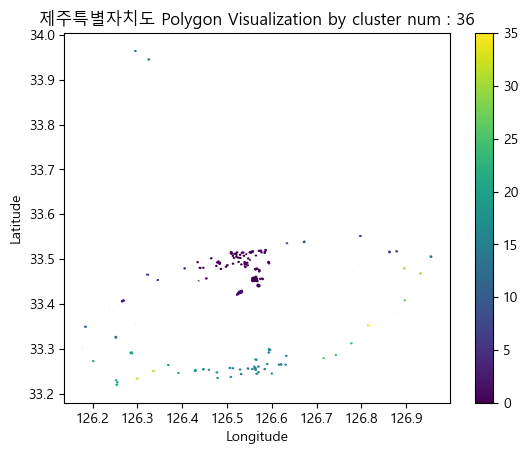

In [27]:
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

for name in names:
    gdf = gdf_dic[name]
    centroids = centroids_dic[name]
    # DBSCAN 군집화를 위하여 세팅
    X = np.array([[point.x, point.y] for point in centroids])

    # 좌표를 스케일링합니다.
    X = StandardScaler().fit_transform(X)

    # DBSCAN 군집화를 실행합니다.
    db = DBSCAN(eps=0.18, min_samples=1).fit(X)
    labels = db.labels_

    # 군집화 결과를 GeoDataFrame에 추가합니다.
    gdf['cluster'] = labels
    gdf_dic[name] = gdf
    
    # Plotting with a legend
    plt.figure(figsize=(10, 10))
    gdf.plot(column='cluster', legend=True)
    plt.title(name + " Polygon Visualization by cluster num : " + str(len(gdf['cluster'].unique())))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

## 각 시도 별로 area sum을 바탕으로 clustering 예정

In [28]:
areasum_dic = {}
for name in names:
    gdf = gdf_dic[name]
    result = gdf.groupby(['cluster'])['area'].sum()
    areasum_dic[name] = result

In [29]:
areasum_dic['경상남도']

cluster
0     0.011912
1     0.004176
2     0.000084
3     0.000434
4     0.000172
        ...   
65    0.000089
66    0.000026
67    0.000027
68    0.000050
69    0.000051
Name: area, Length: 70, dtype: float64

In [30]:
areasum_dic['경상남도'].sum()

0.027371366582736815

In [31]:
len(areasum_dic['경상남도'])

70

In [32]:
print('경상남도의 기준 값 : ' + str(areasum_dic['경상남도'].sum()/len(areasum_dic['경상남도'])))

경상남도의 기준 값 : 0.0003910195226105259


<io>
    위 경상남도의 사례처럼, 현재 정확한 면적 값에 대한 기준이 없기 때문에, dbscan을 이용하여 나눈 클러스터 수를 기준으로, 평균 면적이 각 시,도 별로 할당될 최적 면적이라고 가정하자 <br>
    즉, 기준 면적을 초과하는 클러스터에 대해서는 재 집단구성이 필요하다. <br>

In [33]:
from sklearn.cluster import KMeans

ddf = pd.read_csv('교육환경보호구역_폴리곤.csv', encoding='cp949', index_col=0, low_memory=False)
names = ddf['sido_name'].unique()

area_gizun_dic = {}
for name in names: #각 시도 별로
    gdf = gdf_dic[name]
    areasum = areasum_dic[name]
    area_gizun = areasum.sum()/len(areasum)
    area_gizun_dic[name] = area_gizun
    #총군집수
    all_cluster = len(areasum)
    #기준 충족 군집 수
    areasum_low = areasum[areasum < area_gizun].copy()
    count_low = len(areasum_low) #low 들은 건들일 필요가 없음
    #기준 충족 불가 군집 수
    areasum_high = areasum[areasum >= area_gizun].copy()
    count_high = len(areasum_high)

    for i in areasum_high.index:
        highcluster = gdf[gdf['cluster'] == i].copy()  #high 집단의 첫 번째 (예시)
        higharea = highcluster['area'].sum()
        needcluster = int(2+ (higharea-area_gizun)//area_gizun) #area_gizun 이 예를 들어 3이고, 면적이 7일 경우, 계산 값은 3으로, 7의 면적이 331 이든 3집단으로, 즉 기준 값 이하로 될 수 있는 cluster 수를 계산한것
        #2를 더한 것은 무조건 최소 두개집단으로 higharea 를 나눌 꺼여서, higharea//areagizun + 1 해도 같을 것?
        temp = len(highcluster) #현재 클러스터 내 폴리곤 수, 만일 한 보호구역 자체가 너무 크다면, 집단을 나누는 것이 불가능하기때문에
        if(temp == 1):
            continue
        if(temp == 2):
            kmeans = KMeans(n_clusters=2, n_init=10)
        else:
            if temp >= needcluster:
                kmeans = KMeans(n_clusters=needcluster, n_init=10)  

        #Kmeans 를 하는 기준은, 각 polygon의 centroid를 기준으로 나누어 보도록 하자
        centroids = highcluster['polygon'].apply(get_polygon_centroid)
        highcluster.loc[:, 'x']= centroids.x.copy()
        highcluster.loc[:, 'y']= centroids.y.copy()
        kmeans.fit(highcluster[['x', 'y']])
        label_highcluster = kmeans.predict(highcluster[['x', 'y']])

        highcluster.loc[:, 'new_label'] = label_highcluster.copy() + all_cluster + 1 #기존 label 번호랑 안겹치가 최대 에 0부터 kmeans label이 0부터 시작하니 +1 해줌
        gdf.loc[gdf['cluster']== i, 'cluster'] = highcluster['new_label']

        all_cluster = highcluster['new_label'].max() + 1 #지금 새롭게 cluster 번호가 업데이트 되었으므로, 전체 cluster 수는 현재 추가 업데이트 된 cluster의 최대 치로 변경

총 군집 수 :  25
기준 충족 군집 수 :  21
기준 초과 군집 수 :  4


<Figure size 1000x1000 with 0 Axes>

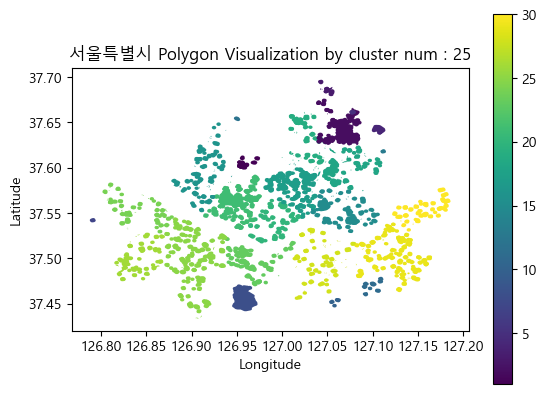

총 군집 수 :  49
기준 충족 군집 수 :  39
기준 초과 군집 수 :  10


<Figure size 1000x1000 with 0 Axes>

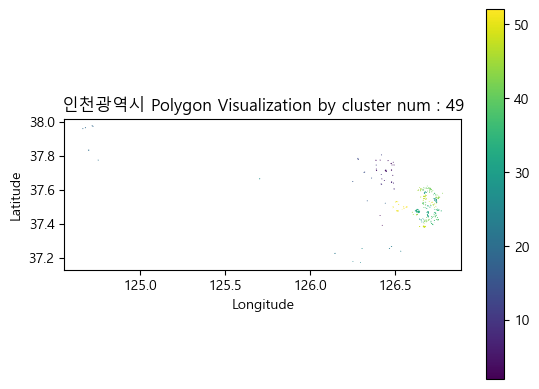

총 군집 수 :  79
기준 충족 군집 수 :  64
기준 초과 군집 수 :  15


<Figure size 1000x1000 with 0 Axes>

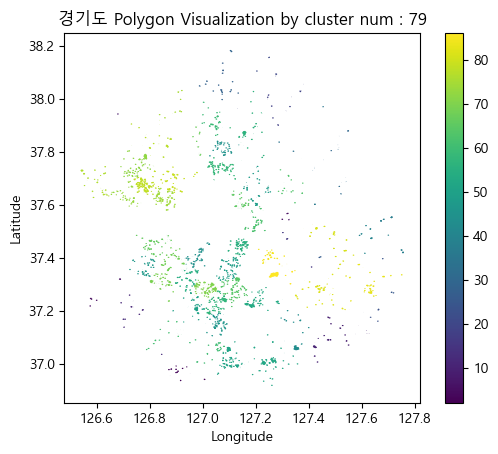

총 군집 수 :  65
기준 충족 군집 수 :  52
기준 초과 군집 수 :  13


<Figure size 1000x1000 with 0 Axes>

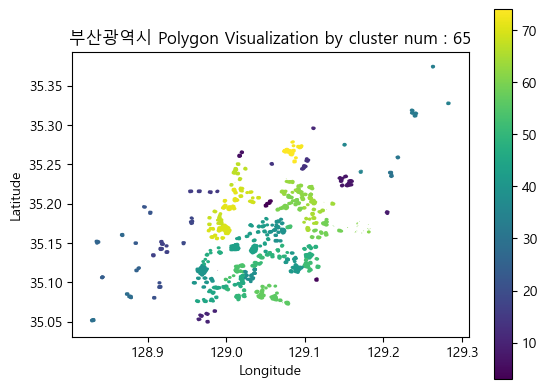

총 군집 수 :  124
기준 충족 군집 수 :  105
기준 초과 군집 수 :  19


<Figure size 1000x1000 with 0 Axes>

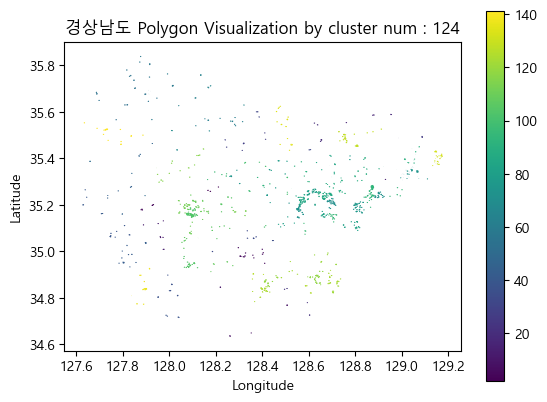

총 군집 수 :  46
기준 충족 군집 수 :  36
기준 초과 군집 수 :  10


<Figure size 1000x1000 with 0 Axes>

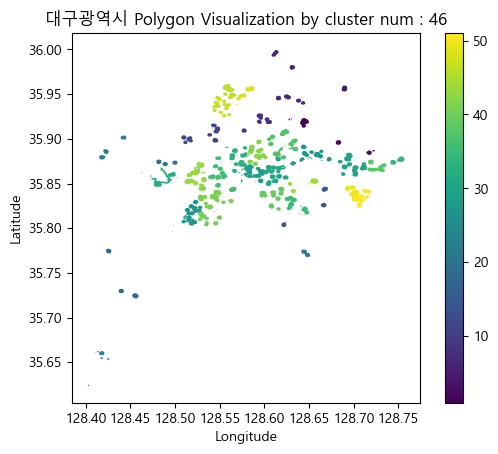

총 군집 수 :  76
기준 충족 군집 수 :  63
기준 초과 군집 수 :  13


<Figure size 1000x1000 with 0 Axes>

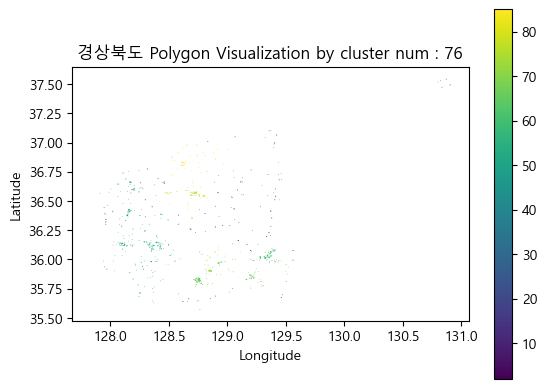

총 군집 수 :  73
기준 충족 군집 수 :  60
기준 초과 군집 수 :  13


<Figure size 1000x1000 with 0 Axes>

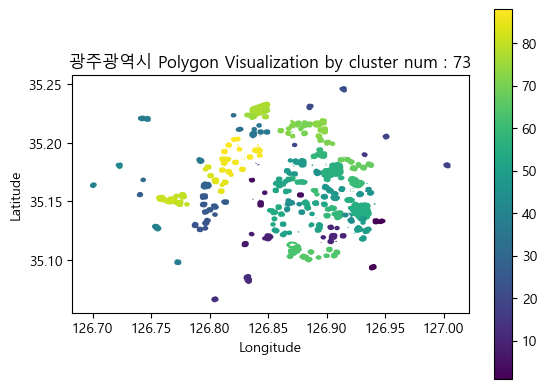

총 군집 수 :  103
기준 충족 군집 수 :  85
기준 초과 군집 수 :  18


<Figure size 1000x1000 with 0 Axes>

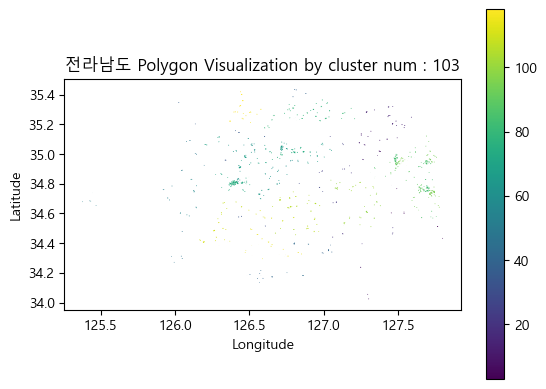

총 군집 수 :  72
기준 충족 군집 수 :  58
기준 초과 군집 수 :  14


<Figure size 1000x1000 with 0 Axes>

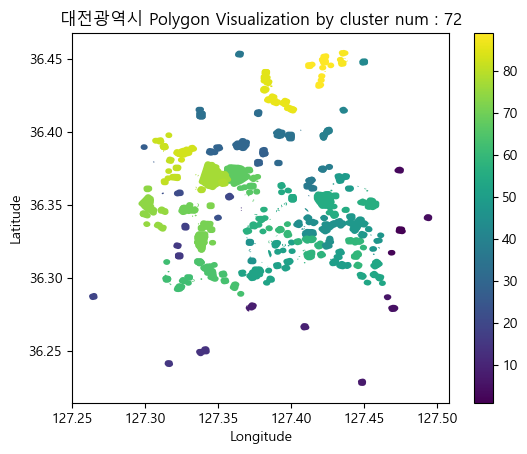

총 군집 수 :  76
기준 충족 군집 수 :  64
기준 초과 군집 수 :  12


<Figure size 1000x1000 with 0 Axes>

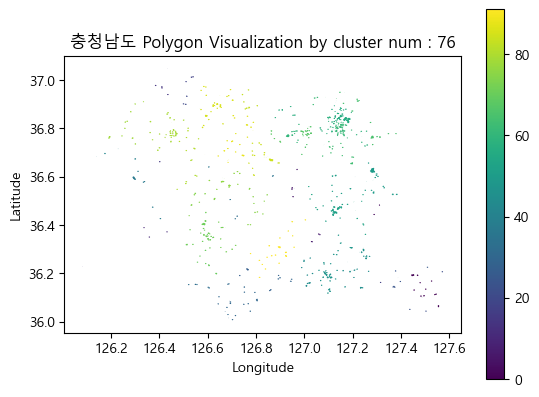

총 군집 수 :  56
기준 충족 군집 수 :  42
기준 초과 군집 수 :  14


<Figure size 1000x1000 with 0 Axes>

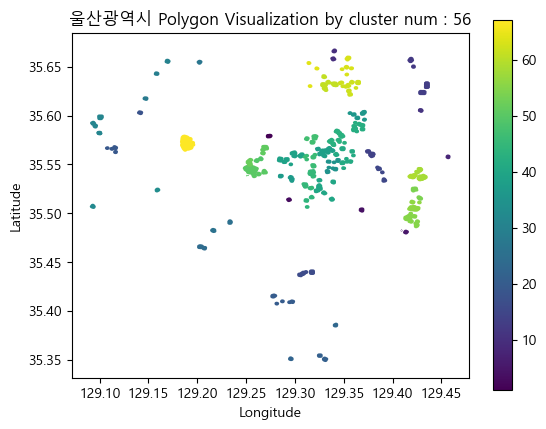

총 군집 수 :  40
기준 충족 군집 수 :  33
기준 초과 군집 수 :  7


<Figure size 1000x1000 with 0 Axes>

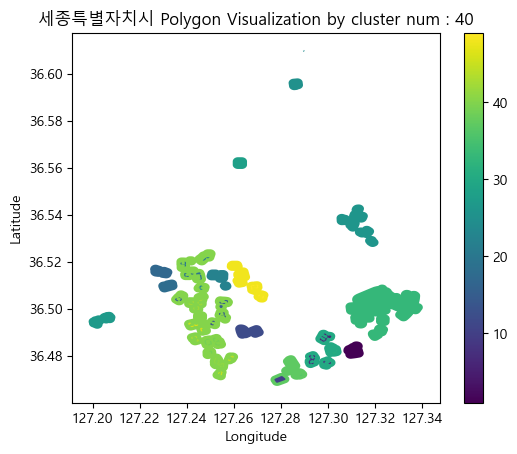

총 군집 수 :  84
기준 충족 군집 수 :  71
기준 초과 군집 수 :  13


<Figure size 1000x1000 with 0 Axes>

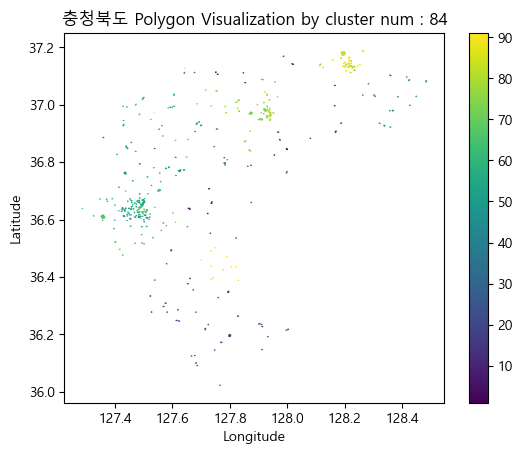

총 군집 수 :  2
기준 충족 군집 수 :  1
기준 초과 군집 수 :  1


<Figure size 1000x1000 with 0 Axes>

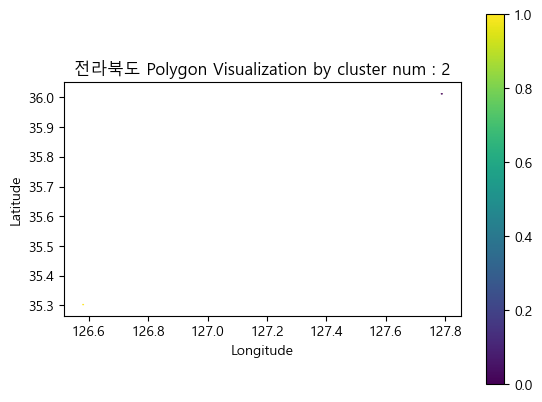

총 군집 수 :  61
기준 충족 군집 수 :  51
기준 초과 군집 수 :  10


<Figure size 1000x1000 with 0 Axes>

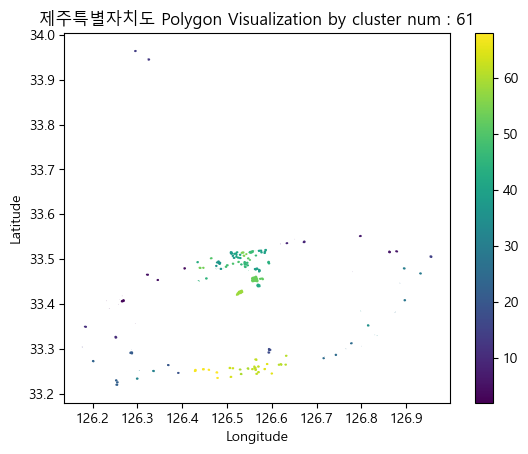

In [34]:
for name in names:
    gdf = gdf_dic[name]
    
    area_gizun = area_gizun_dic[name]
    areasum = gdf.groupby(['cluster'])['area'].sum()
    #총군집수
    all_cluster = len(areasum)
    #기준 충족 군집 수
    count_low = len(areasum[areasum < area_gizun])
    #기준 충족 불가 군집 수
    count_high = len(areasum[areasum >= area_gizun])
    print('총 군집 수 : ', all_cluster)
    print('기준 충족 군집 수 : ', count_low)
    print('기준 초과 군집 수 : ', count_high)
    
        
    # Plotting with a legend
    plt.figure(figsize=(10, 10))
    gdf.plot(column='cluster', legend=True)
    plt.title(name + " Polygon Visualization by cluster num : " + str(len(gdf['cluster'].unique())))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()
    
    

## 기준 충족 못한 집단이 존재하기에, 이것이 한 구역만의 문제인지 알아보기 위해서 같은 코드를 다시한번 진행해봄

In [35]:
from sklearn.cluster import KMeans

ddf = pd.read_csv('교육환경보호구역_폴리곤.csv', encoding='cp949', index_col=0, low_memory=False)
names = ddf['sido_name'].unique()

for name in names: #각 시도 별로
    gdf = gdf_dic[name]
    areasum = gdf.groupby(['cluster'])['area'].sum()
    area_gizun = area_gizun_dic[name]
    #총군집수
    all_cluster = len(areasum)
    #기준 충족 군집 수
    areasum_low = areasum[areasum < area_gizun].copy()
    count_low = len(areasum_low) #low 들은 건들일 필요가 없음
    #기준 충족 불가 군집 수
    areasum_high = areasum[areasum >= area_gizun].copy()
    count_high = len(areasum_high)

    for i in areasum_high.index:
        highcluster = gdf[gdf['cluster'] == i].copy()  #high 집단의 첫 번째 (예시)
        higharea = highcluster['area'].sum()
        needcluster = int(2+ (higharea-area_gizun)//area_gizun) #area_gizun 이 예를 들어 3이고, 면적이 7일 경우, 계산 값은 3으로, 7의 면적이 331 이든 3집단으로, 즉 기준 값 이하로 될 수 있는 cluster 수를 계산한것
        #2를 더한 것은 무조건 최소 두개집단으로 higharea 를 나눌 꺼여서, higharea//areagizun + 1 해도 같을 것?
        temp = len(highcluster) #현재 클러스터 내 폴리곤 수, 만일 한 보호구역 자체가 너무 크다면, 집단을 나누는 것이 불가능하기때문에
        if(temp == 1):
            continue
        if(temp == 2):
            kmeans = KMeans(n_clusters=2, n_init=10)
        else:
            if temp >= needcluster:
                kmeans = KMeans(n_clusters=needcluster, n_init=10)  

        #Kmeans 를 하는 기준은, 각 polygon의 centroid를 기준으로 나누어 보도록 하자
        centroids = highcluster['polygon'].apply(get_polygon_centroid)
        highcluster.loc[:, 'x']= centroids.x.copy()
        highcluster.loc[:, 'y']= centroids.y.copy()
        kmeans.fit(highcluster[['x', 'y']])
        label_highcluster = kmeans.predict(highcluster[['x', 'y']])

        highcluster.loc[:, 'new_label'] = label_highcluster.copy() + all_cluster + 1 #기존 label 번호랑 안겹치가 최대 에 0부터 kmeans label이 0부터 시작하니 +1 해줌
        gdf.loc[gdf['cluster']== i, 'cluster'] = highcluster['new_label']

        all_cluster = highcluster['new_label'].max() + 1 #지금 새롭게 cluster 번호가 업데이트 되었으므로, 전체 cluster 수는 현재 추가 업데이트 된 cluster의 최대 치로 변경

총 군집 수 :  27
기준 충족 군집 수 :  24
기준 초과 군집 수 :  3


<Figure size 1000x1000 with 0 Axes>

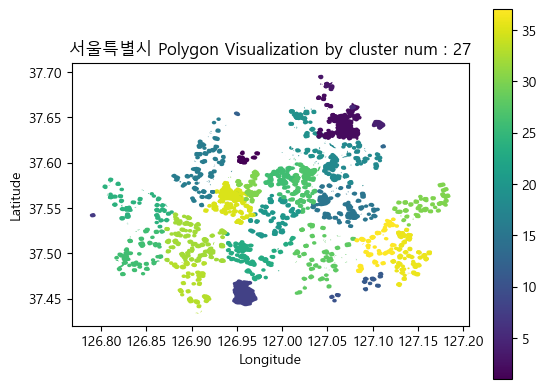

총 군집 수 :  59
기준 충족 군집 수 :  55
기준 초과 군집 수 :  4


<Figure size 1000x1000 with 0 Axes>

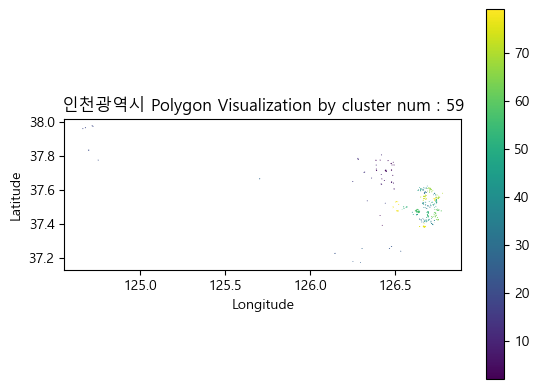

총 군집 수 :  91
기준 충족 군집 수 :  83
기준 초과 군집 수 :  8


<Figure size 1000x1000 with 0 Axes>

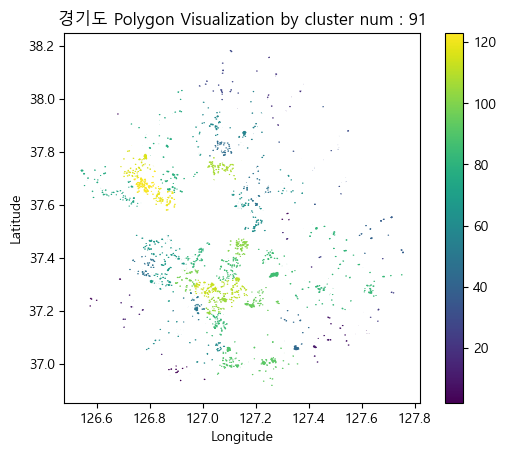

총 군집 수 :  74
기준 충족 군집 수 :  69
기준 초과 군집 수 :  5


<Figure size 1000x1000 with 0 Axes>

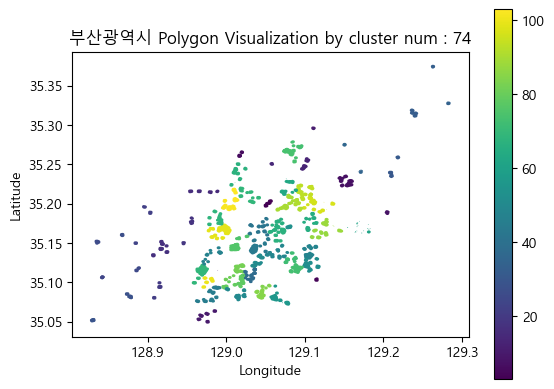

총 군집 수 :  143
기준 충족 군집 수 :  124
기준 초과 군집 수 :  19


<Figure size 1000x1000 with 0 Axes>

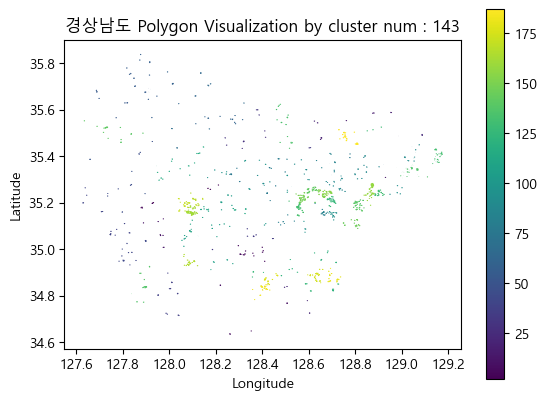

총 군집 수 :  52
기준 충족 군집 수 :  49
기준 초과 군집 수 :  3


<Figure size 1000x1000 with 0 Axes>

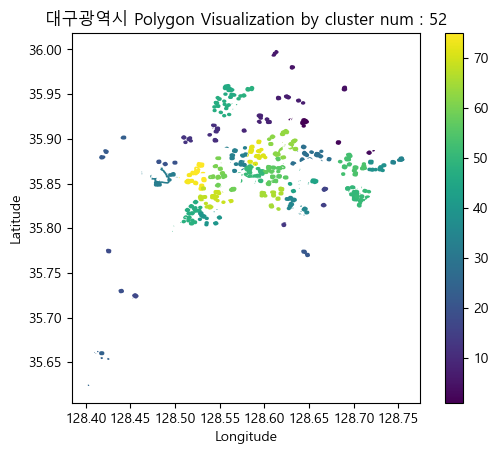

총 군집 수 :  91
기준 충족 군집 수 :  79
기준 초과 군집 수 :  12


<Figure size 1000x1000 with 0 Axes>

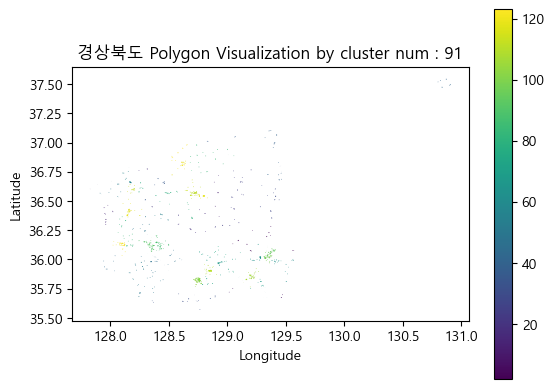

총 군집 수 :  79
기준 충족 군집 수 :  71
기준 초과 군집 수 :  8


<Figure size 1000x1000 with 0 Axes>

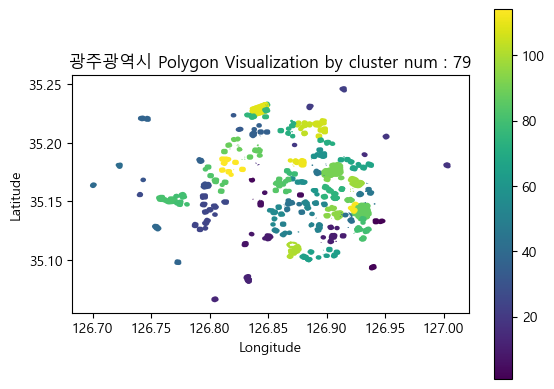

총 군집 수 :  119
기준 충족 군집 수 :  105
기준 초과 군집 수 :  14


<Figure size 1000x1000 with 0 Axes>

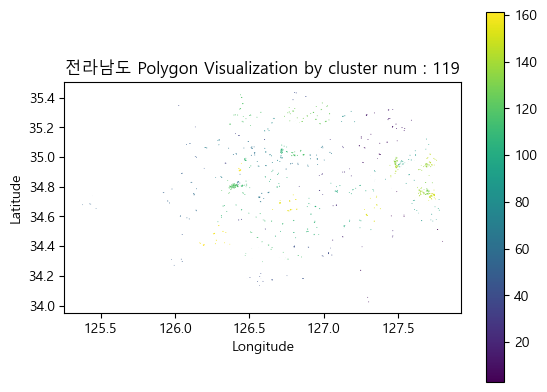

총 군집 수 :  81
기준 충족 군집 수 :  69
기준 초과 군집 수 :  12


<Figure size 1000x1000 with 0 Axes>

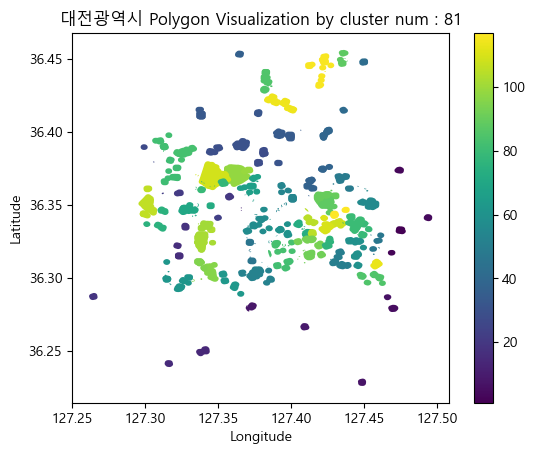

총 군집 수 :  84
기준 충족 군집 수 :  72
기준 초과 군집 수 :  12


<Figure size 1000x1000 with 0 Axes>

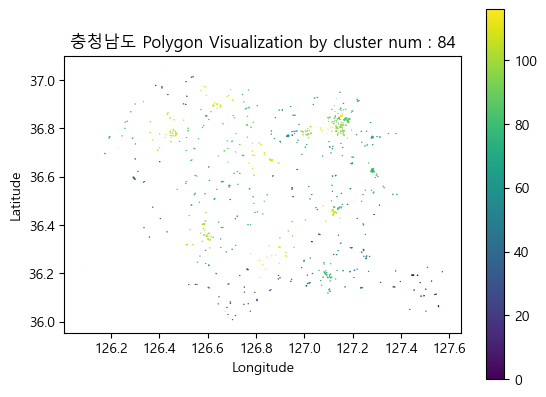

총 군집 수 :  66
기준 충족 군집 수 :  61
기준 초과 군집 수 :  5


<Figure size 1000x1000 with 0 Axes>

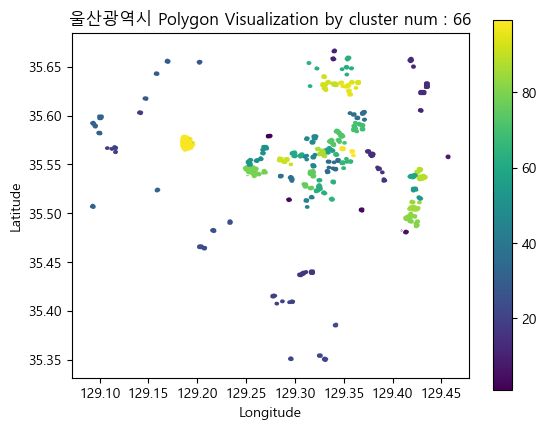

총 군집 수 :  39
기준 충족 군집 수 :  32
기준 초과 군집 수 :  7


<Figure size 1000x1000 with 0 Axes>

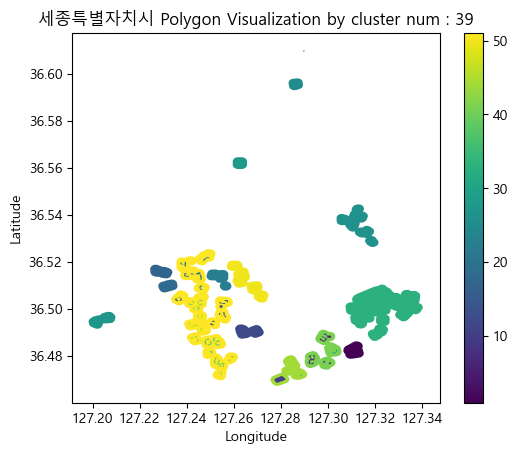

총 군집 수 :  102
기준 충족 군집 수 :  92
기준 초과 군집 수 :  10


<Figure size 1000x1000 with 0 Axes>

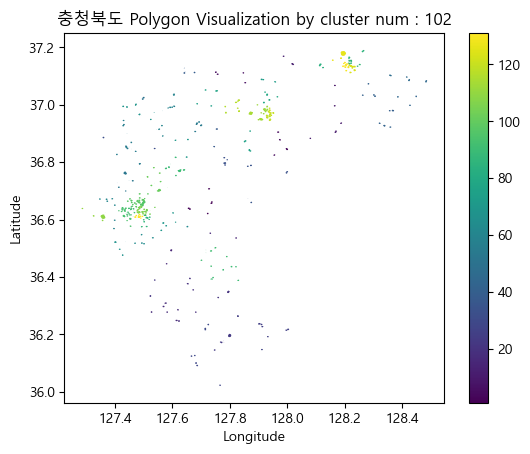

총 군집 수 :  2
기준 충족 군집 수 :  1
기준 초과 군집 수 :  1


<Figure size 1000x1000 with 0 Axes>

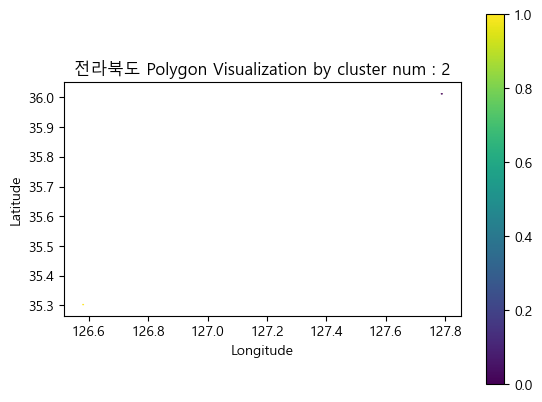

총 군집 수 :  69
기준 충족 군집 수 :  62
기준 초과 군집 수 :  7


<Figure size 1000x1000 with 0 Axes>

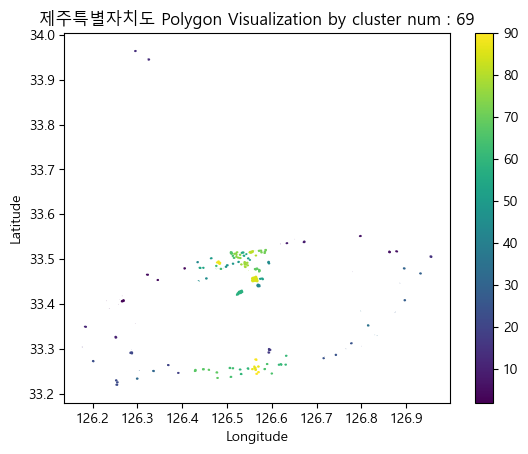

In [36]:
for name in names:
    gdf = gdf_dic[name]
    
    area_gizun = area_gizun_dic[name]
    areasum = gdf.groupby(['cluster'])['area'].sum()
    #총군집수
    all_cluster = len(areasum)
    #기준 충족 군집 수
    count_low = len(areasum[areasum < area_gizun])
    #기준 충족 불가 군집 수
    count_high = len(areasum[areasum >= area_gizun])
    print('총 군집 수 : ', all_cluster)
    print('기준 충족 군집 수 : ', count_low)
    print('기준 초과 군집 수 : ', count_high)
    
        
    # Plotting with a legend
    plt.figure(figsize=(10, 10))
    gdf.plot(column='cluster', legend=True)
    plt.title(name + " Polygon Visualization by cluster num : " + str(len(gdf['cluster'].unique())))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()
    
    

### 반복문으로 여러번 반복한다면?

In [50]:
from sklearn.cluster import KMeans

ddf = pd.read_csv('교육환경보호구역_폴리곤.csv', encoding='cp949', index_col=0, low_memory=False)
names = ddf['sido_name'].unique()

for name in names: #각 시도 별로
    print(name, "시작")
    gdf = gdf_dic[name]
    areasum = gdf.groupby(['cluster'])['area'].sum()
    area_gizun = area_gizun_dic[name]
    #총군집수
    all_cluster = len(areasum)
    #기준 충족 군집 수
    areasum_low = areasum[areasum < area_gizun].copy()
    count_low = len(areasum_low) #low 들은 건들일 필요가 없음
    #기준 충족 불가 군집 수
    areasum_high = areasum[areasum >= area_gizun].copy()
    count_high = len(areasum_high)
    single_polygon = [] #단일 폴리곤, 즉 한 폴리곤 자체가 기준보다 큰 경우를 담기 위해서
    while(count_high > 0): #areasum_high 가 없을 때 까지 그리고 한개 polygon이 너무 커서 안될 때 까지
        for i in areasum_high.index:
            if i in single_polygon:
                # 이미 단일 폴리곤 클러스터로 확인된 경우, 무시
                continue
            
            highcluster = gdf[gdf['cluster'] == i].copy()  #high 집단의 첫 번째 (예시)
            higharea = highcluster['area'].sum()
            needcluster = int(2+ (higharea-area_gizun)//area_gizun) #area_gizun 이 예를 들어 3이고, 면적이 7일 경우, 계산 값은 3으로, 7의 면적이 331 이든 3집단으로, 즉 기준 값 이하로 될 수 있는 cluster 수를 계산한것
            #2를 더한 것은 무조건 최소 두개집단으로 higharea 를 나눌 꺼여서, higharea//areagizun + 1 해도 같을 것?
            temp = len(highcluster) #현재 클러스터 내 폴리곤 수, 만일 한 보호구역 자체가 너무 크다면, 집단을 나누는 것이 불가능하기때문에
            if(temp == 1):
                single_polygon.append(i) #한개이므로 단일 폴리곤으로 포함시켜주자
                continue
            if(temp == 2):
                kmeans = KMeans(n_clusters=2, n_init=10)
            else:
                if temp >= needcluster:
                    kmeans = KMeans(n_clusters=needcluster, n_init=10)  

            #Kmeans 를 하는 기준은, 각 polygon의 centroid를 기준으로 나누어 보도록 하자
            centroids = highcluster['polygon'].apply(get_polygon_centroid)
            highcluster.loc[:, 'x']= centroids.x.copy()
            highcluster.loc[:, 'y']= centroids.y.copy()
            kmeans.fit(highcluster[['x', 'y']])
            label_highcluster = kmeans.predict(highcluster[['x', 'y']])

            highcluster.loc[:, 'new_label'] = label_highcluster.copy() + all_cluster + 1 #기존 label 번호랑 안겹치가 최대 에 0부터 kmeans label이 0부터 시작하니 +1 해줌
            gdf.loc[gdf['cluster']== i, 'cluster'] = highcluster['new_label']

            all_cluster = highcluster['new_label'].max() + 1 #지금 새롭게 cluster 번호가 업데이트 되었으므로, 전체 cluster 수는 현재 추가 업데이트 된 cluster의 최대 치로 변경
    
        areasum = gdf.groupby(['cluster'])['area'].sum().drop(single_polygon) #새롭게 업데이트 된 cluster 기준으로 영역계산, 단 singlepolygon들은 제외
        areasum_high = areasum[areasum >= area_gizun].copy() #새롭게 업데이트된 cluster 기준으로 gizun 보다 높은 것을 확ㅇ니
        count_high = len(areasum_high) #그 수

서울특별시 시작
인천광역시 시작
경기도 시작
부산광역시 시작
경상남도 시작
대구광역시 시작
경상북도 시작
광주광역시 시작
전라남도 시작
대전광역시 시작
충청남도 시작
울산광역시 시작
세종특별자치시 시작
충청북도 시작
전라북도 시작
제주특별자치도 시작


총 군집 수 :  30
기준 충족 군집 수 :  30
기준 초과 군집 수 :  0


<Figure size 1000x1000 with 0 Axes>

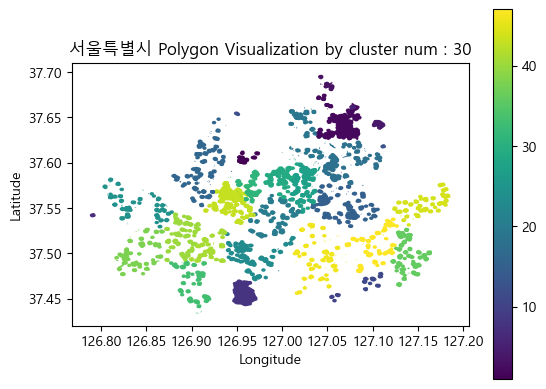

총 군집 수 :  63
기준 충족 군집 수 :  63
기준 초과 군집 수 :  0


<Figure size 1000x1000 with 0 Axes>

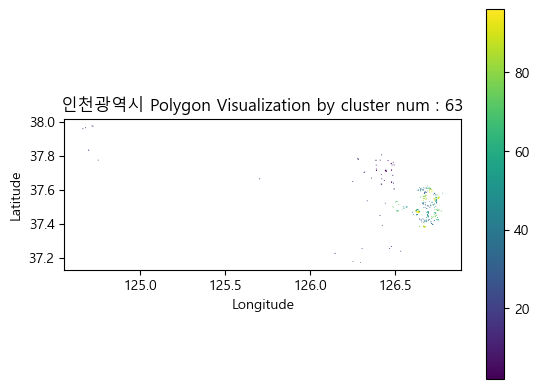

총 군집 수 :  97
기준 충족 군집 수 :  97
기준 초과 군집 수 :  0


<Figure size 1000x1000 with 0 Axes>

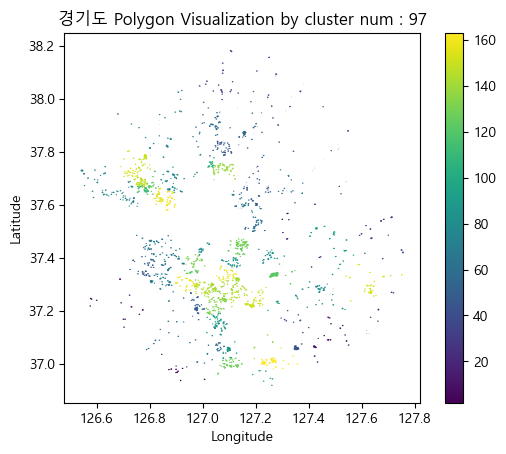

총 군집 수 :  76
기준 충족 군집 수 :  76
기준 초과 군집 수 :  0


<Figure size 1000x1000 with 0 Axes>

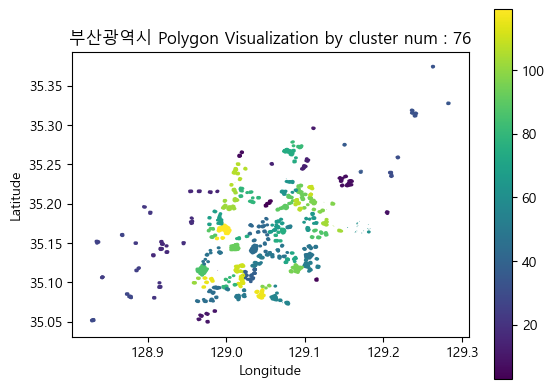

총 군집 수 :  165
기준 충족 군집 수 :  164
기준 초과 군집 수 :  1


<Figure size 1000x1000 with 0 Axes>

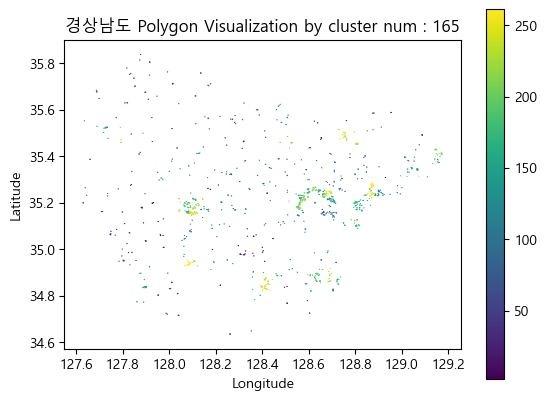

총 군집 수 :  55
기준 충족 군집 수 :  55
기준 초과 군집 수 :  0


<Figure size 1000x1000 with 0 Axes>

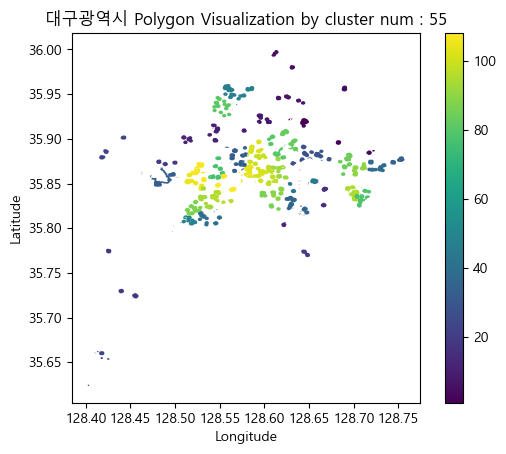

총 군집 수 :  110
기준 충족 군집 수 :  108
기준 초과 군집 수 :  2


<Figure size 1000x1000 with 0 Axes>

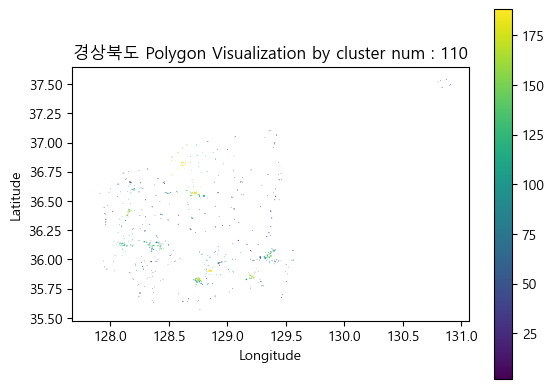

총 군집 수 :  90
기준 충족 군집 수 :  87
기준 초과 군집 수 :  3


<Figure size 1000x1000 with 0 Axes>

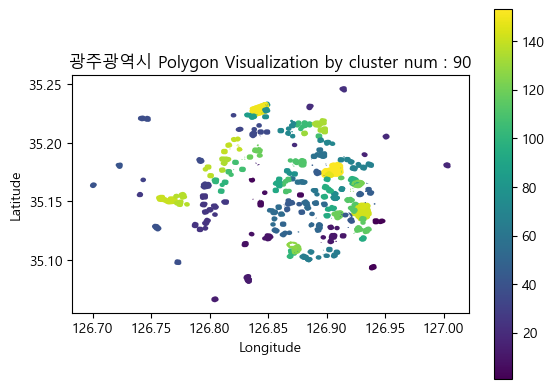

총 군집 수 :  134
기준 충족 군집 수 :  133
기준 초과 군집 수 :  1


<Figure size 1000x1000 with 0 Axes>

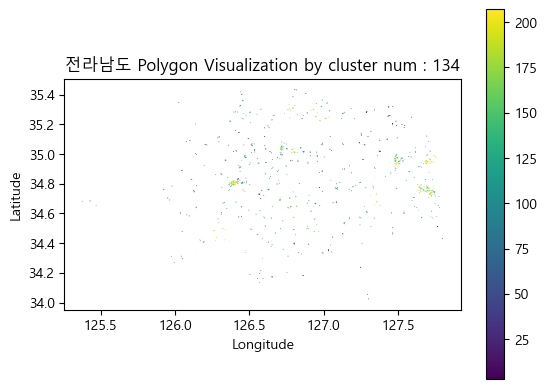

총 군집 수 :  92
기준 충족 군집 수 :  90
기준 초과 군집 수 :  2


<Figure size 1000x1000 with 0 Axes>

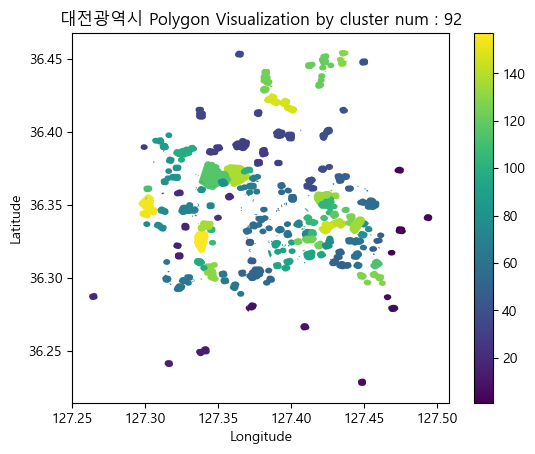

총 군집 수 :  108
기준 충족 군집 수 :  108
기준 초과 군집 수 :  0


<Figure size 1000x1000 with 0 Axes>

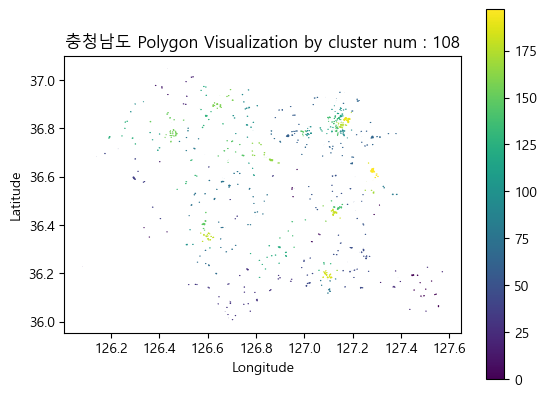

총 군집 수 :  70
기준 충족 군집 수 :  69
기준 초과 군집 수 :  1


<Figure size 1000x1000 with 0 Axes>

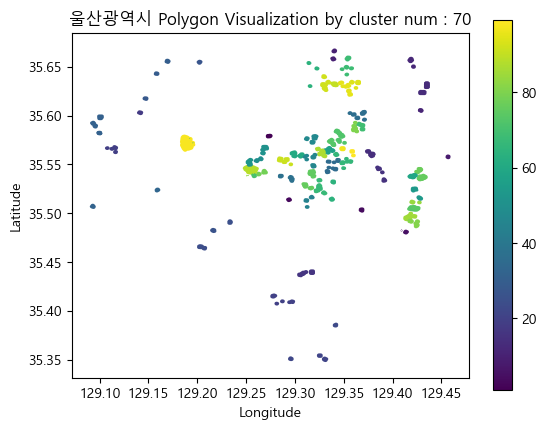

총 군집 수 :  43
기준 충족 군집 수 :  36
기준 초과 군집 수 :  7


<Figure size 1000x1000 with 0 Axes>

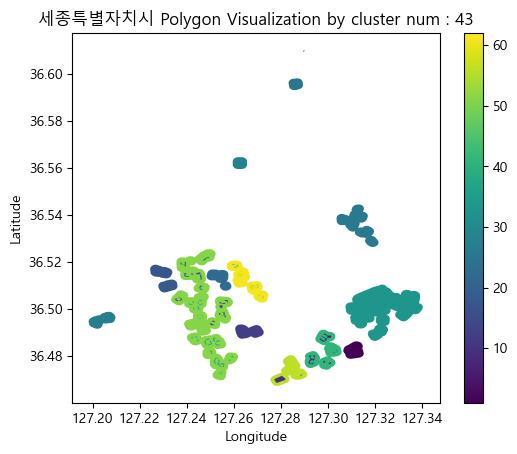

총 군집 수 :  113
기준 충족 군집 수 :  112
기준 초과 군집 수 :  1


<Figure size 1000x1000 with 0 Axes>

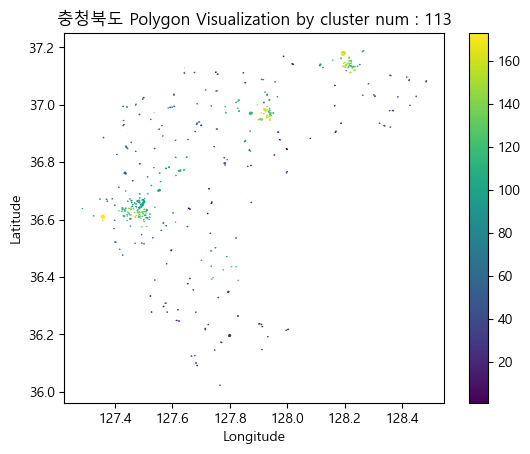

총 군집 수 :  2
기준 충족 군집 수 :  1
기준 초과 군집 수 :  1


<Figure size 1000x1000 with 0 Axes>

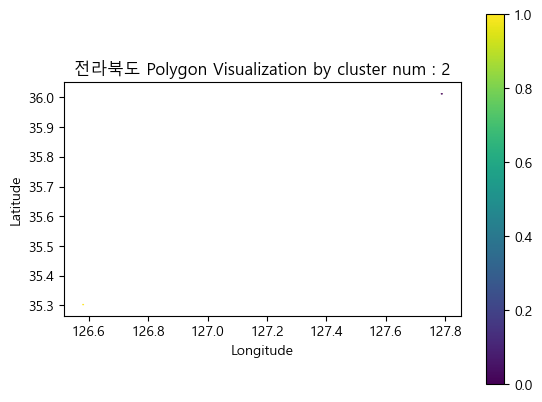

총 군집 수 :  78
기준 충족 군집 수 :  75
기준 초과 군집 수 :  3


<Figure size 1000x1000 with 0 Axes>

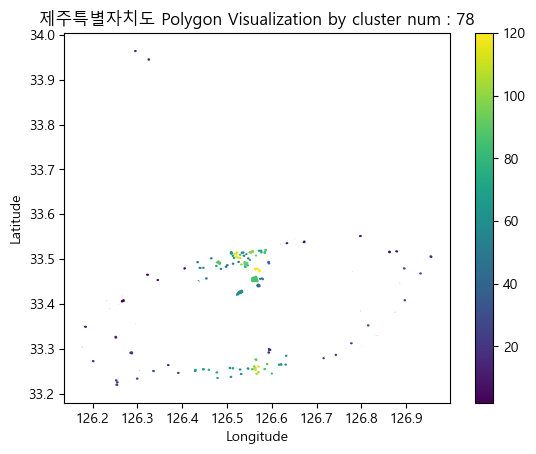

In [51]:
for name in names:
    gdf = gdf_dic[name]
    
    area_gizun = area_gizun_dic[name]
    areasum = gdf.groupby(['cluster'])['area'].sum()
    #총군집수
    all_cluster = len(areasum)
    #기준 충족 군집 수
    count_low = len(areasum[areasum < area_gizun])
    #기준 충족 불가 군집 수
    count_high = len(areasum[areasum >= area_gizun])
    print('총 군집 수 : ', all_cluster)
    print('기준 충족 군집 수 : ', count_low)
    print('기준 초과 군집 수 : ', count_high)
    
        
    # Plotting with a legend
    plt.figure(figsize=(10, 10))
    gdf.plot(column='cluster', legend=True)
    plt.title(name + " Polygon Visualization by cluster num : " + str(len(gdf['cluster'].unique())))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()
    
    

### 결과 분석 및 결론

<io>
    기준 초과 군집 수는 단일 폴리곤이 애초에 기준값을 넘는 경우로, 그 내에서 나누는 것은 정확한 폴리곤 경계 등을 알 수 없다. <br>
    따라서 각 시,도 관계자들은 이러한 방법을 응용하여, 직원수 할당을 통하여 교육환경구역에 직원 배분 등이 가능할 것이며 <br>
    DBscan과 clustering을 이용한 이러한 방식은 비단 geometry 영역 뿐만 아니라, <br>
    물류, 금융 권 등에서도 충분히 사용이 가능할 것 이다. <br>
    대표적으로 유사한 기업들의 자산 등을 추정할 때, 유사한 기업을 묶는 기준 중 하나가 이러한 방법이 될 것 이며 <br>
    비정상적인 거래 패턴 식별을 통한 사기 탐지, 포토폴리오 내 위험 평가 시 위험요소를 가진 자산 군집화 등 <br>
    다양한 분야에서도 적용 가능할 것으로 기대된다.
    

<io>
    "Constrained K-Means Clustering" 논문과 유사하게 area_gizun이라는 제약조건을 바탕으로 충족되지 않은 경우 <br>
    다시 그 군집에서 clustering 하도록 유도하고 있다. 하지만 반복문 보다는 기존의 알고리즘 수정 혹은 딥러닝 방식 등도 가능하지 않을까 생각이 들어 <br>
    조금더 관련 논문 등을 통하여 최적화 방법에 대해서 고민이 필요할 것으로 보인다. 